# Proteomics dimethyl-labeling

# Statistical Analysis

This notebook contains statistical analysis of proteomic dataset available in [PRIDE PXD000497](https://www.ebi.ac.uk/pride/archive/projects/PXD000497) as BRAF_Wholeproteome_MaxQuant_Output.zip.

Most of this analysis uses the output of the data processing workflow (`.pickle` file).

In [1]:
%matplotlib inline
%load_ext autoreload

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import padua
import padua.visualize as viz
import padua.analysis as analysis
import numpy as np
import os
import matplotlib.cm as cm

In [2]:
# Load and read input files
SOURCE_FILE =  r'proteinGroups-processed.pickle'
DESIGN_FILE = r'design.csv'

df = pd.read_pickle(SOURCE_FILE)

In [3]:
# Define where to save output files
SOURCE_FOLDER = os.path.dirname(SOURCE_FILE)
BASENAME = os.path.splitext(os.path.basename(SOURCE_FILE))[0]

## PCA

Principal component analysis is used to have a quick look at the quality of the data. A define a colourscheme is used to visualize different experimental groups. Colours are defined in hex notation and available here: https://github.com/mbostock/d3/wiki/Ordinal-Scales#categorical-colors. The Weight by PCA reflects the relevance of the proteins with respect to the distribution of data respect to principal component 1 and 2.

In [4]:
GROUP_COLORS = {
    '1day/control': '#dd1a1a',  #red
    '3days/control': '#5d6cdd', #blue
    '3days/1day': '#f2a707'     #orange
}

EDGE_COLORS = {
    '1day/control': '#dd1a1a',
    '3days/control': '#5d6cdd',
    '3days/1day': '#f2a707'
}

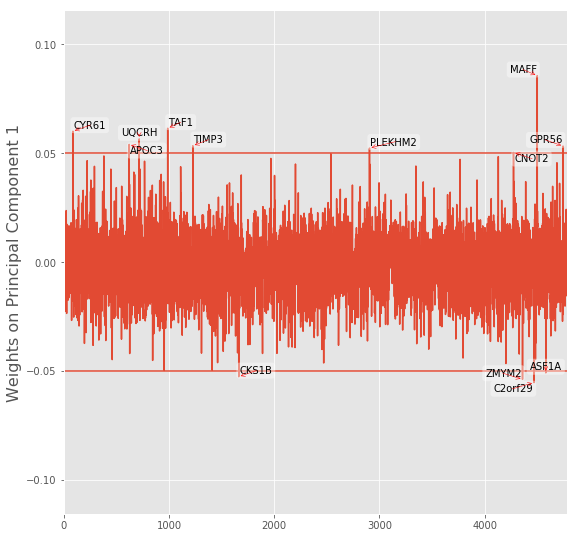

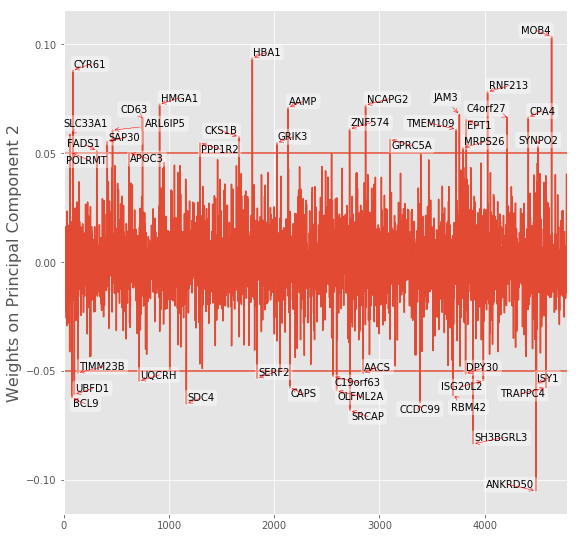

In [5]:
%autoreload 2

axes = viz.pca(df, fcol= GROUP_COLORS, ecol=EDGE_COLORS, threshold=0.05, label_threshold=0.05, markersize=100, label_weights=['Gene names'], label_scores= ['Group', 'Replicate'])
axes[0].figure.savefig( os.path.join(SOURCE_FOLDER,  BASENAME + '-pca-scores.tiff'), bbox_inches='tight', dpi=300 )
axes[1][0].figure.savefig(os.path.join(SOURCE_FOLDER,  BASENAME + '-pca-weights-1.tiff'), bbox_inches='tight', dpi=300)
axes[1][1].figure.savefig(os.path.join(SOURCE_FOLDER,  BASENAME + '-pca-weights-2.tiff'), bbox_inches='tight', dpi=300)

scores, weights = analysis.pca(df)
weights.to_csv( os.path.join(SOURCE_FOLDER,  BASENAME + '-pca-weights.csv') )

## Volcano Plot

Significantly changed proteins are calculated by using a one-sample or two-samples t-test. Resuts can be visualized through a volcano plot. 

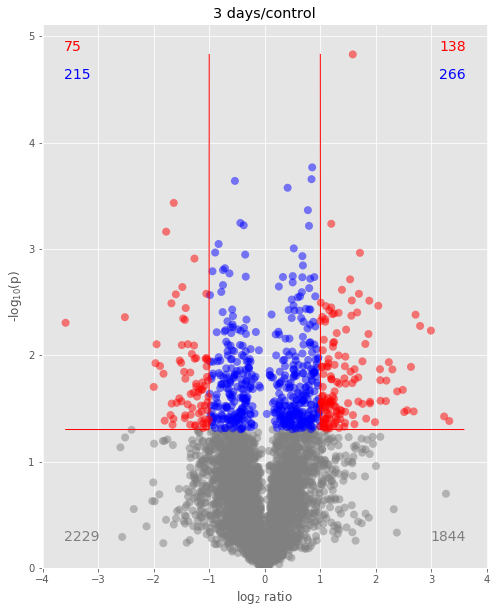

In [6]:
%autoreload 2

# One-sample t-test
ax, p, dr, filtered_3d_ctr = viz.volcano(df, ('3days/control'), labels_from=['Gene names'], is_log2=True, title='3 days/control', label_sig_only=True)
ax.figure.savefig(os.path.join(SOURCE_FOLDER,  BASENAME + '-volcano-3d-ctr.tiff'), bbox_inches='tight', dpi=300)

dfx = df.copy()[ ['3days/control'] ].reset_index()
dfx['P'] = p
dfx['Log2(ratio)'] = dr
dfx.to_csv( os.path.join(SOURCE_FOLDER,  BASENAME + '-volcano-3d-ctr-unfiltered.csv') )
dfx = dfx[filtered_3d_ctr]
dfx.to_csv( os.path.join(SOURCE_FOLDER,  BASENAME + '-volcano-3d-ctr-filtered.csv') )

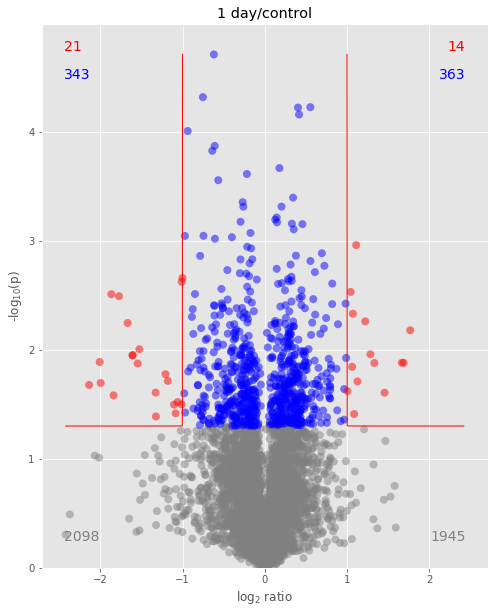

In [7]:
%autoreload 2

# One-sample t-test
ax, p, dr, filtered_1d_ctr = viz.volcano(
    df, 
    ('1day/control'), 
    labels_from=['Gene names'], 
    is_log2=True, 
    title='1 day/control'
)
ax.figure.savefig(os.path.join(SOURCE_FOLDER,  BASENAME + '-volcano-1d-ctr.tiff'), bbox_inches='tight', dpi=300)

dfx = df.copy()[ ['1day/control'] ].reset_index()
dfx['P'] = p
dfx['Log2(ratio)'] = dr
dfx.to_csv( os.path.join(SOURCE_FOLDER,  BASENAME + '-volcano-1d-ctr-unfiltered.csv') )
dfx = dfx[filtered_1d_ctr]
dfx.to_csv( os.path.join(SOURCE_FOLDER,  BASENAME + '-volcano-1d-ctr-filtered.csv') )

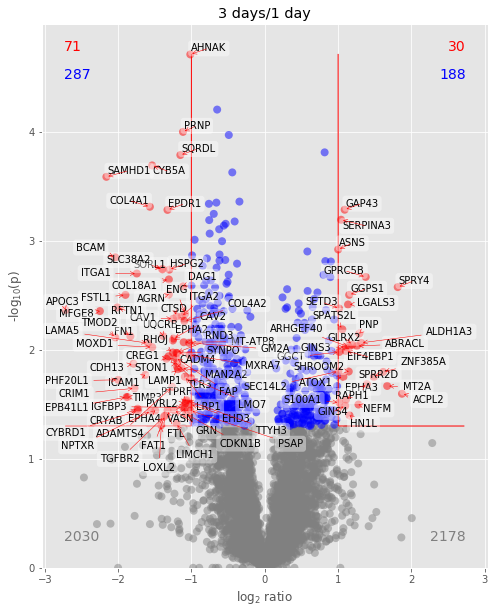

In [8]:
%autoreload 2

# Two-sample t-test
ax, p, dr, filtered_3d_1d = viz.volcano(
    df, 
    ('3days/control'), ('1day/control'), 
    labels_for=True, 
    label_sig_only=True, 
    labels_from=['Gene names'], 
    is_log2=True, 
    title='3 days/1 day',
    optimize_label_iter=500  # High value takes a long time to process, however ensures better layout.
)
ax.figure.savefig(os.path.join(SOURCE_FOLDER,  BASENAME + '-volcano-3d-1d.tiff'), bbox_inches='tight', dpi=300)

dfx = df.copy()[ ['3days/control', '1day/control'] ].reset_index()
dfx['P'] = p
dfx['Log2(ratio)'] = dr
dfx.to_csv( os.path.join(SOURCE_FOLDER, BASENAME + '-volcano-3d-1d-unfiltered.csv') )
dfx = dfx[filtered_3d_1d]
dfx.to_csv( os.path.join(SOURCE_FOLDER, BASENAME + '-volcano-3d-1d-filtered.csv') )

## GO enrichment

The enrichment analysis is performed on the significant up-regulated proteins at 3 days respect to 1 day.

In [9]:
%autoreload 2
up_filtered_3d_1d = dfx[dfx['Log2(ratio)'] >= 1]
up_filtered_3d_1d.shape

(30, 15)

In [10]:
up_filtered_3d_1d.set_index(['id', 'Protein IDs', 'Gene names', 'Proteins', 'Ratio M/L normalized', 'Ratio H/L normalized', 'Ratio H/M normalized' ], inplace=True)

In [11]:
up_filtered_3d_1d.head()

Group                                                                                                3days/control  \
Replicate                                                                                                        1   
id  Protein IDs   Gene names Proteins Ratio M/L normalized Ratio H/L normalized Ratio H/M normalized                 
130 O00244        ATOX1      1         0.040542            -0.973611            -1.206362                -0.877261   
528 O75223        GGCT       1         0.077927            -0.619381            -1.070088                -0.464425   
631 O76054;Q9UDX4 SEC14L2    2        -0.112007            -0.957216            -1.037088                -0.706512   
745 O95749        GGPS1      1         0.313710            -0.798366            -0.824188                -0.397771   
786 P00491        PNP        1        -0.070770            -1.085252            -1.286621                -0.836810   

Group                                                                                                           \
Replicate                                                                                                    2   
id  Protein IDs   Gene names Proteins Ratio M/L normalized Ratio H/L normalized Ratio H/M normalized             
130 O00244        ATOX1      1         0.040542            -0.973611            -1.206362            -0.609795   
528 O75223        GGCT       1         0.077927            -0.619381            -1.070088            -0.908388   
631 O76054;Q9UDX4 SEC14L2    2        -0.112007            -0.957216            -1.037088            -1.480116   
745 O95749        GGPS1      1         0.313710            -0.798366            -0.824188            -0.798366   
786 P00491        PNP        1        -0.070770            -1.085252            -1.286621            -1.476659   

Group                                                                                                           \
Replicate                                                                                                    3   
id  Protein IDs   Gene names Proteins Ratio M/L normalized Ratio H/L normalized Ratio H/M normalized             
130 O00244        ATOX1      1         0.040542            -0.973611            -1.206362            -1.508527   
528 O75223        GGCT       1         0.077927            -0.619381            -1.070088            -1.173092   
631 O76054;Q9UDX4 SEC14L2    2        -0.112007            -0.957216            -1.037088            -1.060788   
745 O95749        GGPS1      1         0.313710            -0.798366            -0.824188            -0.941393   
786 P00491        PNP        1        -0.070770            -1.085252            -1.286621            -1.599112   

Group                                                                                                1day/control  \
Replicate                                                                                                       1   
id  Protein IDs   Gene names Proteins Ratio M/L normalized Ratio H/L normalized Ratio H/M normalized                
130 O00244        ATOX1      1         0.040542            -0.973611            -1.206362                0.214125   
528 O75223        GGCT       1         0.077927            -0.619381            -1.070088                0.016924   
631 O76054;Q9UDX4 SEC14L2    2        -0.112007            -0.957216            -1.037088               -0.239260   
745 O95749        GGPS1      1         0.313710            -0.798366            -0.824188                0.303576   
786 P00491        PNP        1        -0.070770            -1.085252            -1.286621                0.160404   

Group                                                                                                           \
Replicate                                                                                                    2   
id  Protein IDs   Gene names Proteins Ratio M/L normalized Ratio

In [12]:
%autoreload 2

goenrich_pathway = analysis.go_enrichment(up_filtered_3d_1d, enrichment='pathway',ids_from=['Protein IDs'])
goenrich_pathway

P       FDR
GO     Name                                                      
P02730 Asparagine and aspartate biosynthesis     0.0071  0.578559
P02769 Purine metabolism                         0.0113  0.615858
P02723 Adenine and hypoxanthine salvage pathway  0.0113  0.461893
P00014 Cholesterol biosynthesis                  0.0198  0.643990
P04372 5-Hydroxytryptamine degredation           0.0295  0.801130
P04397 p53 pathway by glucose deprivation        0.0336  0.783168

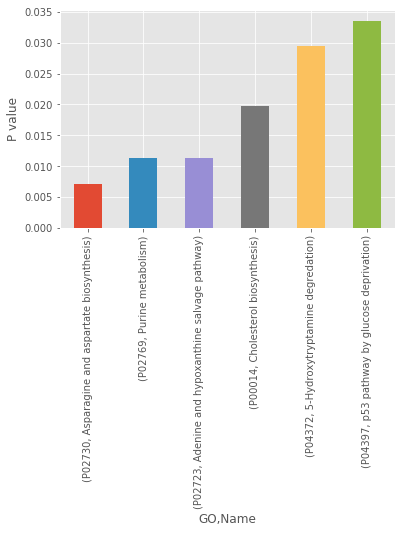

In [13]:
%autoreload 2

enrich_plot= goenrich_pathway.plot.bar(y="P", legend=None)
enrich_plot.set_ylabel('P value')
enrich_plot.figure.savefig(os.path.join(SOURCE_FOLDER,  BASENAME + '-go-enrich-pathway-3d-1d.tiff'), bbox_inches='tight', dpi=300)

## Venn diagram

This analysis allows to calculate the overlap significant proetins quantified in each group.

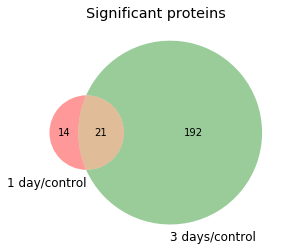

In [14]:
%autoreload 2

ax = viz.venn(df.iloc[filtered_1d_ctr], df.iloc[filtered_3d_ctr], labels=["1 day/control", "3 days/control"])
ax.set_title("Significant proteins")
ax.figure.savefig( os.path.join(SOURCE_FOLDER,  BASENAME + '-venn-significant.tiff'), bbox_inches='tight', dpi=300 )
df[filtered_1d_ctr & filtered_3d_ctr].to_csv(os.path.join(SOURCE_FOLDER,  BASENAME + '-venn-significant-common.csv') )

## Boxplot

In [15]:
%autoreload 2

s = 'NRAS'
figs= viz.box(df, s, groups=['1day/control', '3days/control',], fcol=GROUP_COLORS)
figs[0].savefig(os.path.join(SOURCE_FOLDER, BASENAME + '-box-plot-NRAS.tiff'), bbox_inches='tight', dpi=300)

## KEGG pathway analysis

Pathway analysis is performed to compare changing in protein expressions after drug treatment over time. 

In [16]:
%autoreload 2

image = viz.kegg_pathway(df, 'hsa04010', '1day/control', ids_from="Protein IDs", is_log2=True, fillna=0, z_score=1)
image.save( os.path.join(SOURCE_FOLDER,  BASENAME + '-kegg-mapk-1d.png'), bbox_inches='tight')
image

Scale range: -1.92 .. 1.92


Scale range: -1.78 .. 1.78


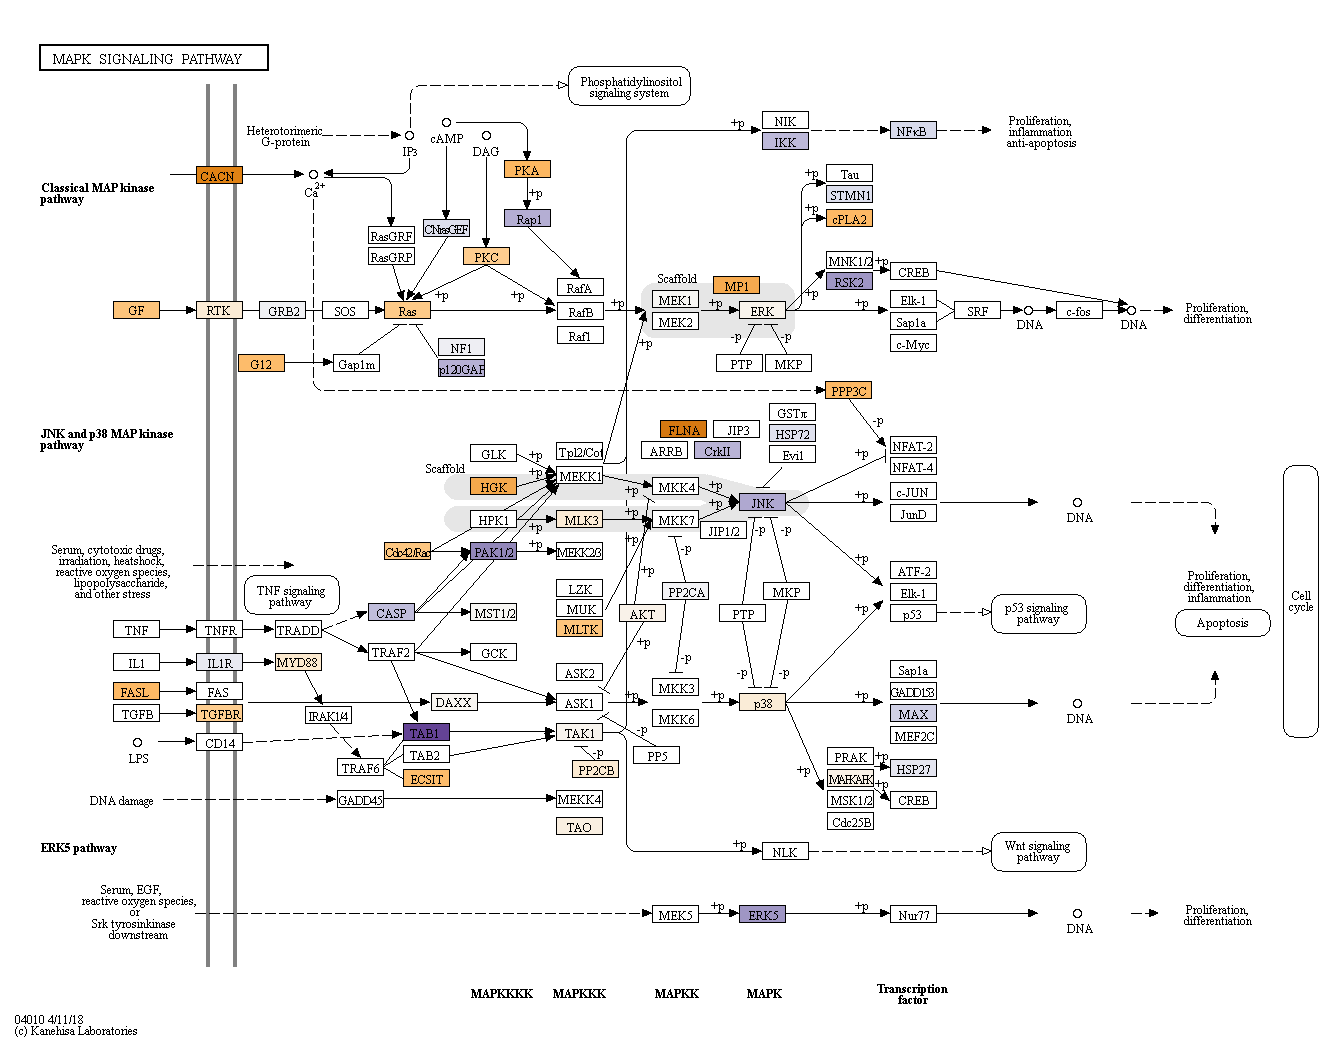

In [17]:
%autoreload 2

image = viz.kegg_pathway(df, 'hsa04010', '3days/control', ids_from="Protein IDs", is_log2=True, fillna=0, z_score=1)
image.save( os.path.join(SOURCE_FOLDER,  BASENAME + '-kegg-mapk-3d.png'), bbox_inches='tight')
image